# Build Your Neural Network In Cairo 1.0 with Orion

Orion is a dedicated Cairo-based library designed specifically to build machine learning models for ValidityML. Its purpose is to facilitate verifiable inference. For better performance we will operate with an 8-bit quantized model. In this tutorial, you will be guided on how to train your model using Quantized Aware Training using MNIST dataset, how to convert your pre-trained model to Cairo 1, and how to perform inference with Orion.

## Install Dependecies, Rust, Cairo and Scarb
Let's start by installing all dependecies.

In [1]:
import sys
!{sys.executable} -m pip install numpy tensorflow tensorflow_model_optimization matplotlib scipy

In [ ]:
!curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh -s -- -y

In [ ]:
# Create .cairo folder if it doesn't exist yet
! mkdir $HOME/.cairo

! source "$HOME/.cargo/env"

# Clone the Cairo compiler in $CAIRO_ROOT (default root)
! cd $HOME/.cairo && git clone https://github.com/starkware-libs/cairo.git .

# OPTIONAL/RECOMMENDED: If you want to install a specific version of the compiler
# Fetch all tags (versions)
! git fetch --all --tags
# View tags (you can also do this in the cairo compiler repository)
! git describe --tags `git rev-list --tags`
# Checkout the version you want
! git checkout tags/v1.1.0

# Generate release binaries
! cd $HOME/.cairo && $HOME/.cargo/bin/cargo build --all --release

In [ ]:
# Install Scarb
! curl --proto '=https' --tlsv1.2 -sSf https://docs.swmansion.com/scarb/install.sh | sh

## Train and Test your Neural Network with Tensorflow
In this section we will use Tensorflow to train and test a feedforward neural network with MNIST dataset.

### Dataset Preparation
Import the required libraries and load the dataset.

In [2]:
from tensorflow import keras
from keras.datasets import mnist
from scipy.ndimage import zoom
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

We have a total of 70,000 grayscale images, each with a dimension of 28 x 28 pixels. 60,000 images are for training and the remaining 10,000 are for testing. 

We now need to pre-process our data. For the purposes of this tutorial and performance, we'll resize the images to 14 x 14 pixels. You'll see later that the neural network's input layer supports a 1D tensor. We, therefore, need to flatten and normalize our data.

In [3]:
from scipy.ndimage import zoom

# Resizing function
def resize_images(images):
    return np.array([zoom(image, 0.5) for image in images])

# Resize
x_train = resize_images(x_train)
x_test = resize_images(x_test)

# Then reshape
x_train = x_train.reshape(60000, 14*14)
x_test = x_test.reshape(10000, 14*14)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# normalize to range [0, 1]
x_train /= 255
x_test /= 255

### Model Definition and Training
We will design a straightforward feedforward neural network.

In [4]:
from tensorflow.keras import layers

num_classes = 10

model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(14*14,)),
    keras.layers.Dense(10, activation='relu'), 
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


Now let's train this model on our training data.

In [5]:
batch_size = 256
epochs = 10
history = model.fit(x_train, y_train,
                    epochs=epochs,
                    validation_split=0.2)


Epoch 1/10
1500/1500 [==============================] - 1s 449us/step - loss: 0.8094 - accuracy: 0.7795 - val_loss: 0.3885 - val_accuracy: 0.8953
Epoch 2/10
1500/1500 [==============================] - 1s 399us/step - loss: 0.3693 - accuracy: 0.8961 - val_loss: 0.3152 - val_accuracy: 0.9122
Epoch 3/10
1500/1500 [==============================] - 1s 402us/step - loss: 0.3239 - accuracy: 0.9072 - val_loss: 0.2905 - val_accuracy: 0.9185
Epoch 4/10
1500/1500 [==============================] - 1s 403us/step - loss: 0.3041 - accuracy: 0.9130 - val_loss: 0.2842 - val_accuracy: 0.9192
Epoch 5/10
1500/1500 [==============================] - 1s 428us/step - loss: 0.2931 - accuracy: 0.9162 - val_loss: 0.2716 - val_accuracy: 0.9237
Epoch 6/10
1500/1500 [==============================] - 1s 406us/step - loss: 0.2849 - accuracy: 0.9193 - val_loss: 0.2689 - val_accuracy: 0.9228
Epoch 7/10
1500/1500 [==============================] - 1s 407us/step - loss: 0.2791 - accuracy: 0.9202 - val_loss: 0.2645 -

At this point, we have trained a regular model.



### Making the Model Quantization Aware
Now, let's transform our model into a quantization aware model. We use the TensorFlow Model Optimization Toolkit for this.


In [6]:
import tensorflow_model_optimization as tfmot

# Apply quantization to the layers
quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for 'quantization aware'
q_aware_model = quantize_model(model)

# 'quantize_model' requires a recompile
q_aware_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLa  (None, 196)               3         
 yer)                                                            
                                                                 
 quant_dense (QuantizeWrapp  (None, 10)                1975      
 erV2)                                                           
                                                                 
 quant_dense_1 (QuantizeWra  (None, 10)                115       
 pperV2)                                                         
                                                                 
Total params: 2093 (8.18 KB)
Trainable params: 2080 (8.12 KB)
Non-trainable params: 13 (52.00 Byte)
_________________________________________________________________


We have now created a new model, q_aware_model, which is a quantization aware version of our original model. Now we can train this model exactly like our original model.

In [7]:
batch_size = 256
epochs = 10
history = q_aware_model.fit(x_train, y_train,
                            epochs=epochs,
                            validation_split=0.2)

scores, acc = q_aware_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores)
print('Test accuracy:', acc)

Epoch 1/10
1500/1500 [==============================] - 1s 526us/step - loss: 0.2671 - accuracy: 0.9236 - val_loss: 0.2581 - val_accuracy: 0.9283
Epoch 2/10
1500/1500 [==============================] - 1s 478us/step - loss: 0.2625 - accuracy: 0.9235 - val_loss: 0.2538 - val_accuracy: 0.9293
Epoch 3/10
1500/1500 [==============================] - 1s 491us/step - loss: 0.2602 - accuracy: 0.9246 - val_loss: 0.2521 - val_accuracy: 0.9308
Epoch 4/10
1500/1500 [==============================] - 1s 481us/step - loss: 0.2579 - accuracy: 0.9265 - val_loss: 0.2541 - val_accuracy: 0.9296
Epoch 5/10
1500/1500 [==============================] - 1s 481us/step - loss: 0.2557 - accuracy: 0.9271 - val_loss: 0.2490 - val_accuracy: 0.9317
Epoch 6/10
1500/1500 [==============================] - 1s 482us/step - loss: 0.2540 - accuracy: 0.9274 - val_loss: 0.2492 - val_accuracy: 0.9313
Epoch 7/10
1500/1500 [==============================] - 1s 497us/step - loss: 0.2522 - accuracy: 0.9277 - val_loss: 0.2495 -

### Converting to TFLite Format
Now, we will convert our model to TFLite format, which is a format optimized for on-device machine learning.

In [8]:
import tensorflow as tf

# Create a converter
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)

# Indicate that you want to perform default optimizations,
# which include quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Define a generator function that provides your test data's numpy arrays
def representative_data_gen():
  for i in range(500):
    yield [x_test[i:i+1]]

# Use the generator function to guide the quantization process
converter.representative_dataset = representative_data_gen

# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Set the input and output tensors to int8
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Convert the model
tflite_model = converter.convert()

# Save the model to disk
open("q_aware_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/s3/6c0gmns50x36dt6vvfhv6jhc0000gn/T/tmpwwestso3/assets


INFO:tensorflow:Assets written to: /var/folders/s3/6c0gmns50x36dt6vvfhv6jhc0000gn/T/tmpwwestso3/assets
/Users/raphaeldoukhan/Desktop/Orion-Giza/Academy/Tutorials/orion_tutorials/.conda/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-09-08 08:57:11.760815: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-09-08 08:57:11.760826: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-09-08 08:57:11.761006: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/s3/6c0gmns50x36dt6vvfhv6jhc0000gn/T/tmpwwestso3
2023-09-08 08:57:11.761945: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-09-08 08:57:11.761951: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if pres

4312

### Testing the Quantized Model
Now that we have trained a quantization-aware model and converted it to the TFLite format, we can now perform inference using the TensorFlow Lite interpreter.


We first load the TFLite model and allocate the required tensors. The Interpreter class provides methods for loading a model and running inferences.



In [9]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="q_aware_model.tflite")
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Next, we get the details of the input and output tensors. Each tensor in a TensorFlow Lite model has a name, index, shape, data type, and quantization parameters. These can be accessed via the input_details and output_details methods.

In [10]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


Before performing the inference, we need to normalize the input to match the data type of our model's input tensor, which in our case is int8. Then, we use the set_tensor method to provide the input data to the model. We perform the inference using the invoke method.

In [11]:
# Normalize the input value to int8
input_shape = input_details[0]['shape']
input_data = np.array(x_test[0:1], dtype=np.int8)
interpreter.set_tensor(input_details[0]['index'], input_data)

# Perform the inference
interpreter.invoke()


After the inference, we get the output data from the model's output tensor.

Now, we are going to run the inference for the entire test set:

In [12]:
# Get the result
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)


[[-122 -128  -22  -67 -128  -47 -128 -127 -128 -128]]


We normalize the entire test set and initialize an array to store the predictions.



In [13]:
(_, _), (x_test_image, y_test_label) = mnist.load_data()

# Resize and Normalize x_test_image to int8
x_test_image = resize_images(x_test_image)
x_test_image_norm = (x_test_image / 255.0 * 255 - 128).astype(np.int8)

# Initialize an array to store the predictions
predictions = []


We then iterate over the test set, making predictions for each image. For each image, we flatten the image, normalize it, and then expand its dimensions to match the shape of our model's input tensor.



In [14]:
# Iterate over the test data and make predictions
for i in range(len(x_test_image_norm)):
    test_image = np.expand_dims(x_test_image_norm[i].flatten(), axis=0)
    
    # Set the value for the input tensor
    interpreter.set_tensor(input_details[0]['index'], test_image)
    
    # Run the inference
    interpreter.invoke()

    output = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(output)


Finally, we use a function to plot the test images along with their predicted labels. This will give us a visual representation of how well our model is performing.

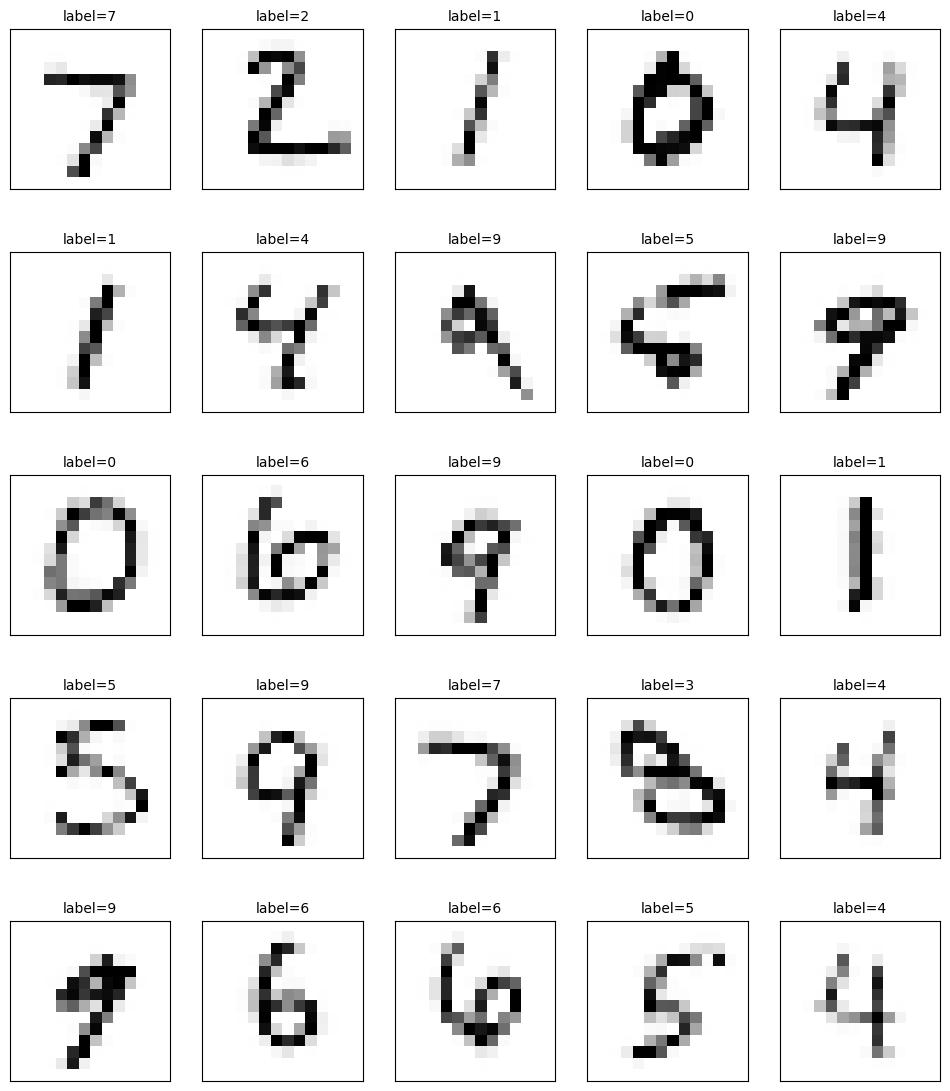

In [15]:
import matplotlib.pyplot as plt

def plot_images_labels_prediction(images,labels,idx,num=10):
    fig=plt.gcf()
    fig.set_size_inches(12, 14)
    if num > 25: num=25
    for i in range(0, num):
        ax=plt.subplot(5, 5, i+1)
        ax.imshow(images[idx], cmap='binary')
        title="label=" + str(labels[idx])
        ax.set_title(title, fontsize=10)
        ax.set_xticks([]);
        ax.set_yticks([]);
        idx += 1
    plt.show()

plot_images_labels_prediction(x_test_image, y_test_label, 0, 25)


That's it! We have successfully trained a quantization-aware model, converted it to the TFLite format, and performed inference using the TensorFlow Lite interpreter.

## Convert your model to Orion's Cairo code
In this section you will generate Cairo files for each bias and weight of the model. 

In [19]:
import numpy as np
import tensorflow as tf
import os


# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="q_aware_model.tflite")
interpreter.allocate_tensors()

# Create an object with all tensors (an input + all weights and biases)
tensors = {
    "input": x_test_image[0].flatten(), #7
    "fc1_weights": interpreter.get_tensor(1), 
    "fc1_bias": interpreter.get_tensor(2), 
    "fc2_weights": interpreter.get_tensor(4), 
    "fc2_bias": interpreter.get_tensor(5)
}

# Create the directory if it doesn't exist
os.makedirs('src/generated', exist_ok=True)

for tensor_name, tensor in tensors.items():
    with open(os.path.join('src', 'generated', f"{tensor_name}.cairo"), "w") as f:
        f.write(
            "use array::ArrayTrait;\n" +
            "use orion::operators::tensor::{TensorTrait, Tensor, I32Tensor};\n" +
            "use orion::numbers::i32;\n\n" +
            "\nfn {0}() -> Tensor<i32> ".format(tensor_name) + "{\n" +
            "    let mut shape = ArrayTrait::<usize>::new();\n"
        )
        for dim in tensor.shape:
            f.write("    shape.append({0});\n".format(dim))
        f.write(
            "    let mut data = ArrayTrait::<i32>::new();\n"
        )
        for val in np.nditer(tensor.flatten()):
            f.write("    data.append(i32 {{ mag: {0}, sign: {1} }});\n".format(abs(int(val)), str(val < 0).lower()))
        f.write(
            "    TensorTrait::new(shape.span(), data.span())\n" +
            "}\n"
        )
      
with open(os.path.join('src', 'generated.cairo'), 'w') as f:
    for param_name in tensors.keys():
        f.write(f"mod {param_name};\n")


## Build your NN with Cairo and Orion
In this section you will perform inference with Cairo and Orion.


Create the `nn.cairo` file in which we'll build the neural network functions.

In [17]:
! touch src/nn.cairo

Let's create the two dense layer functions of the neural network: `fc1` and `fc2`.

In [20]:
%%writefile src/nn.cairo
use orion::operators::tensor::core::Tensor;
use orion::numbers::signed_integer::{integer_trait::IntegerTrait, i32::i32};
use orion::operators::nn::{NNTrait, I32NN};

fn fc1(i: Tensor<i32>, w: Tensor<i32>, b: Tensor<i32>) -> Tensor<i32> {
    let x = NNTrait::linear(i, w, b);
    NNTrait::relu(@x)
}

fn fc2(i: Tensor<i32>, w: Tensor<i32>, b: Tensor<i32>) -> Tensor<i32> {
    NNTrait::linear(i, w, b)
}


Overwriting src/nn.cairo


We will make predictions in a test. First, create the testing file.

In [21]:
! touch src/test.cairo

Let's now define the input data and parameters generated earlier, and set the neural network.
The input data represents the number 7. The probability at index 7 must therefore be close to 1.

In [22]:
%%writefile src/test.cairo
use core::array::SpanTrait;

use mnist_nn::nn::fc1;
use mnist_nn::nn::fc2;
use mnist_nn::generated::input::input;
use mnist_nn::generated::fc1_bias::fc1_bias;
use mnist_nn::generated::fc1_weights::fc1_weights;
use mnist_nn::generated::fc2_bias::fc2_bias;
use mnist_nn::generated::fc2_weights::fc2_weights;

use orion::operators::tensor::I32Tensor;

#[test]
#[available_gas(99999999999999999)]
fn mnist_nn_test() {
    let input = input();
    let fc1_bias = fc1_bias();
    let fc1_weights = fc1_weights();
    let fc2_bias = fc2_bias();
    let fc2_weights = fc2_weights();

    let x = fc1(input, fc1_weights, fc1_bias);
    let x = fc2(x, fc2_weights, fc2_bias);

    let x = *x.argmax(0, Option::None(()), Option::None(())).data.at(0);

    assert(x == 7, 'should predict 7');
}



Overwriting src/test.cairo


Run the following cell to test your file.

In [ ]:
! scarb run test